**Install required packages**

In [ ]:
!pip install imblearn shap

**Import necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

**Load Dataset**

In [ ]:
df = pd.read_csv('/content/pmjay_claims_expanded.csv')
df.head()

,Claim_ID,Patient_Age,Gender,State,Hospital_Type,Hospital_Bed_Count,Procedure_Type,Claim_Amount,Preauth_Approved,Claim_Approved
0,CLM0001,56,Male,Uttar Pradesh,Public,28,Pediatric,25841.00,Yes,Yes
1,CLM0002,19,Female,Rajasthan,Private,180,Medical,15271.72,No,Yes
2,CLM0003,76,Female,Bihar,Public,459,Pediatric,17151.01,No,Yes
3,CLM0004,65,Female,Bihar,Public,83,Surgical,7555.57,Yes,Yes
4,CLM0005,25,Female,Bihar,Private,70,Medical,2416.21,No,Yes


**Data Pre-Processing**

In [ ]:
X = df.drop(columns=['Claim_ID', 'Claim_Approved'])
y = df['Claim_Approved'].map({'Yes': 1, 'No': 0})
X_original = X.copy()
categorical = ['Gender', 'State', 'Hospital_Type', 'Procedure_Type', 'Preauth_Approved']
numerical = ['Patient_Age', 'Hospital_Bed_Count', 'Claim_Amount']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical),
    ('num', StandardScaler(), numerical)
        ])
X_processed = preprocessor.fit_transform(X)

**Building the Model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8047 - loss: 0.5635 - val_accuracy: 0.8813 - val_loss: 0.3745
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8449 - loss: 0.4453 - val_accuracy: 0.8813 - val_loss: 0.3724
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8270 - loss: 0.4586 - val_accuracy: 0.8813 - val_loss: 0.3783
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8317 - loss: 0.4537 - val_accuracy: 0.8813 - val_loss: 0.3747
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8471 - loss: 0.4193 - val_accuracy: 0.8813 - val_loss: 0.3781
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8596 - loss: 0.3947 - val_accuracy: 0.8813 - val_loss: 0.3815
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8425 - loss: 0.4176 - val_accuracy: 0.8813 - val_loss: 0.3719
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8332 - loss: 0.4298 - val_accuracy: 0.8813 - val_loss: 0.3777
Ep

**Evaluation Metrics**

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.25      0.03      0.05        35
           1       0.83      0.98      0.90       165

    accuracy                           0.81       200
   macro avg       0.54      0.51      0.47       200
weighted avg       0.73      0.81      0.75       200



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


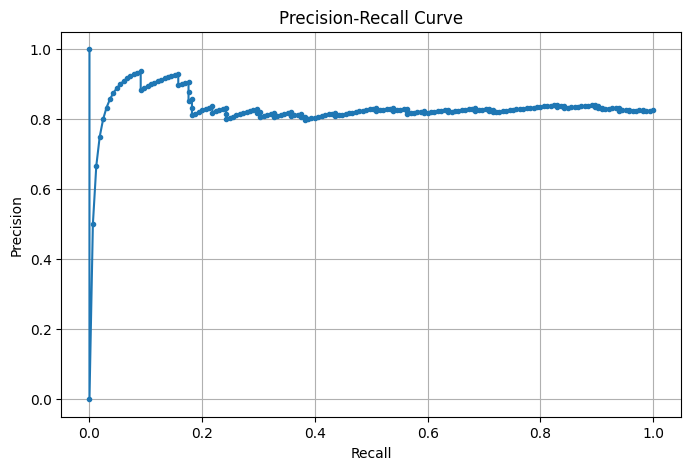

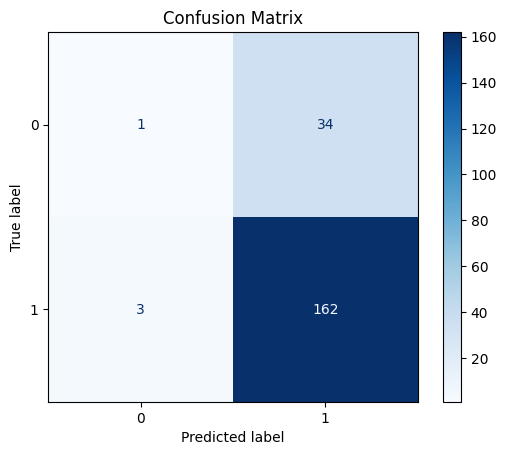

In [ ]:
from sklearn.metrics import precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


**Applying SHAP**

In [ ]:
explainer = shap.Explainer(model, X_train[:100].astype(np.float32))
shap_values = explainer(X_test[:50].astype(np.float32))

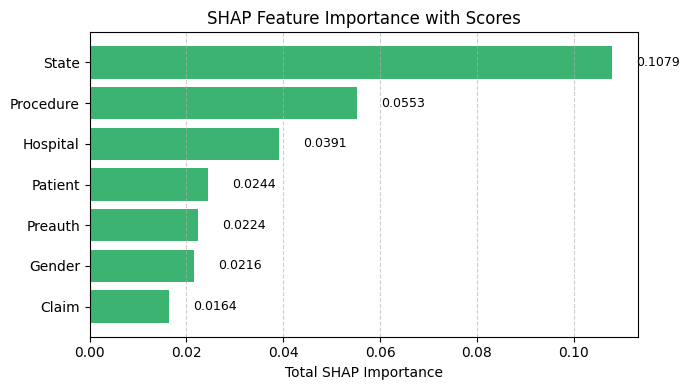

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical)
all_feature_names = list(ohe_feature_names) + numerical

shap_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': np.abs(shap_values.values).mean(axis=0)
})
def simplify_feature_name(name):
    if '_' in name:
        return name.split('_')[0]
    return name
shap_df['grouped_feature'] = shap_df['feature'].apply(simplify_feature_name)
grouped_shap = shap_df.groupby('grouped_feature')['importance'].sum().sort_values(ascending=True)

plt.figure(figsize=(7, 4))
bars = plt.barh(grouped_shap.index, grouped_shap.values, color='mediumseagreen')
plt.xlabel("Total SHAP Importance")
plt.title("SHAP Feature Importance with Scores")
plt.grid(axis='x', linestyle='--', alpha=0.6)
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
                    f'{width:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

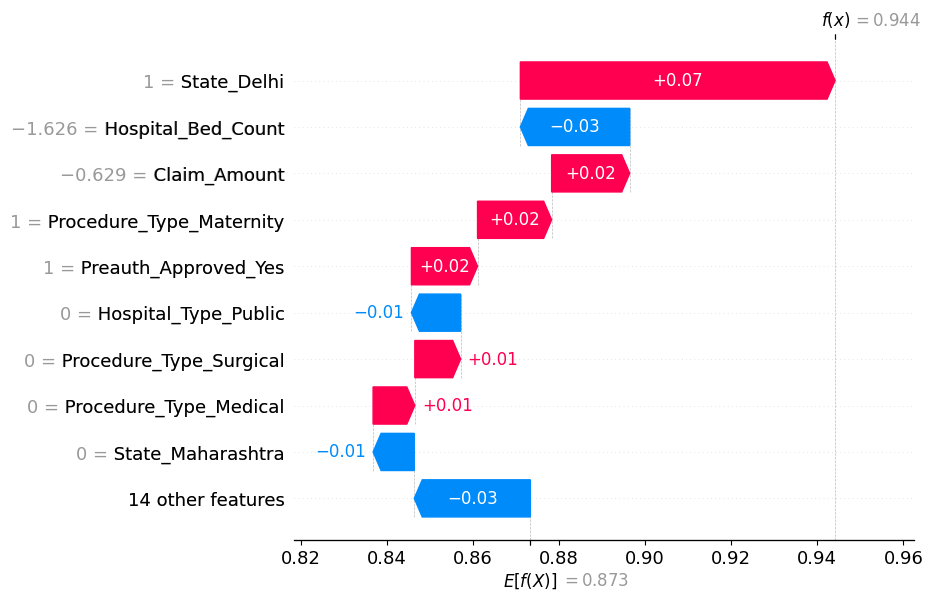

In [ ]:
explainer = shap.Explainer(model, X_train[:100].astype(np.float32))
shap_values = explainer(X_test[:1].astype(np.float32))
feature_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + numerical
shap_values_for_one_instance = shap_values[0]
shap_values_for_one_instance.feature_names = feature_names
shap.waterfall_plot(shap_values_for_one_instance)

PermutationExplainer explainer: 101it [00:11,  1.06s/it]


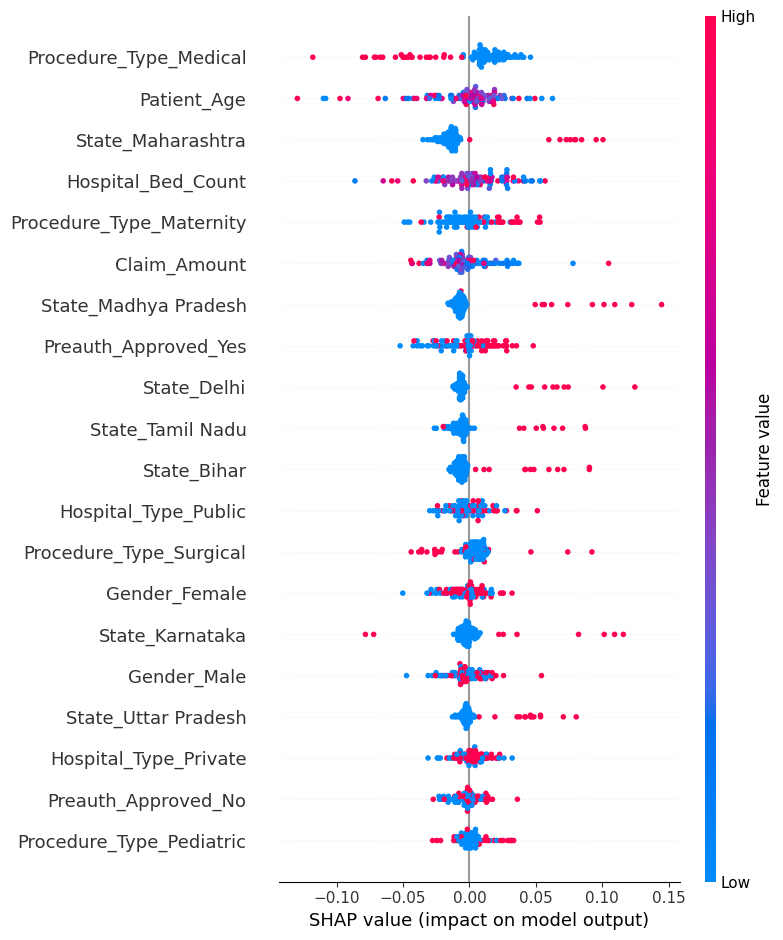

In [ ]:
explainer = shap.Explainer(model, X_train[:100].astype(np.float32))
shap_values = explainer(X_test[:100].astype(np.float32))
ohe_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(categorical)
feature_names = list(ohe_feature_names) + numerical
shap_values.feature_names = feature_names
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)

**Bias Detection**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_original, y, test_size=0.2, random_state=42
)
y_pred_binary = (model.predict(X_test) > 0.5).astype(int)
bias_df = pd.DataFrame({
    'TrueLabel': y_test.values,
    'Predicted': y_pred_binary.flatten(),
    'Gender': X_test_orig['Gender'].values,
    'Hospital_Type': X_test_orig['Hospital_Type'].values
})
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_bias_metrics(df, group_col):
    for group in df[group_col].dropna().unique():
        subset = df[df[group_col] == group]
        acc = accuracy_score(subset['TrueLabel'], subset['Predicted'])
        prec = precision_score(subset['TrueLabel'], subset['Predicted'], zero_division=0)
        rec = recall_score(subset['TrueLabel'], subset['Predicted'], zero_division=0)
        f1 = f1_score(subset['TrueLabel'], subset['Predicted'], zero_division=0)
        print(f"\n Metrics for {group_col}: {group}")
        print(f"Accuracy:  {acc:.2f}")
        print(f"Precision: {prec:.2f}")
        print(f"Recall:    {rec:.2f}")
        print(f"F1 Score:  {f1:.2f}")

print_bias_metrics(bias_df, 'Gender')
print_bias_metrics(bias_df, 'Hospital_Type')


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

 Metrics for Gender: Male
Accuracy:  0.79
Precision: 0.81
Recall:    0.97
F1 Score:  0.88

 Metrics for Gender: Female
Accuracy:  0.83
Precision: 0.84
Recall:    0.99
F1 Score:  0.91

 Metrics for Hospital_Type: Private
Accuracy:  0.83
Precision: 0.85
Recall:    0.97
F1 Score:  0.91

 Metrics for Hospital_Type: Public
Accuracy:  0.78
Precision: 0.78
Recall:    1.00
F1 Score:  0.88


**Ethical Redesign**

**a. Ethical Data Gathering**

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)

**b. Ethical Data Preprocessing**

In [ ]:
sensitive = ['Gender', 'Hospital_Type']
X_fair = df.drop(columns=['Claim_ID', 'Claim_Approved'] + sensitive)
y = df['Claim_Approved'].map({'Yes': 1, 'No': 0})
X_original = X_fair.copy()
categorical = ['State', 'Procedure_Type', 'Preauth_Approved']
numerical = ['Patient_Age', 'Hospital_Bed_Count', 'Claim_Amount']
preprocessor = ColumnTransformer([
      ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical),
      ('num', StandardScaler(), numerical)
])
X_processed = preprocessor.fit_transform(X_fair)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32)
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5119 - loss: 0.6905 - val_accuracy: 0.5444 - val_loss: 0.6923
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5764 - loss: 0.6747 - val_accuracy: 0.5778 - val_loss: 0.6818
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5900 - loss: 0.6630 - val_accuracy: 0.5963 - val_loss: 0.6579
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6556 - loss: 0.6316 - val_accuracy: 0.6630 - val_loss: 0.6389
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6722 - loss: 0.6027 - val_accuracy: 0.6593 - val_loss: 0.6327
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7281 - loss: 0.5709 - val_accuracy: 0.6815 - val_loss: 0.5845
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7217 - loss: 0.5435 - val_accuracy: 0.7037 - val_loss: 0.5757
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7160 - loss: 0.5399 - val_accuracy: 0.7111 - val_loss: 0.5585
E

**c. Ethical Modelling**

In [ ]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_difference, demographic_parity_difference
sensitive_feature = X_test_orig['Gender']
base_model = LogisticRegression(solver='liblinear')

In [ ]:
constraint = DemographicParity()
fair_model = ExponentiatedGradient(base_model, constraints=constraint)
fair_model.fit(X_train, y_train, sensitive_features=X_train_orig['Gender'])

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x7d5cad0ae1d0>,
                      estimator=LogisticRegression(solver='liblinear'),
                      nu=0.006337736808480387)

In [ ]:
y_fair_pred = fair_model.predict(X_test)
metric_frame = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'selection_rate': selection_rate
    },
    y_true=y_test,
    y_pred=y_fair_pred,
    sensitive_features=sensitive_feature
)
print("Fairness Metrics by Gender:")
print(metric_frame.by_group)

disparate_impact_gender = demographic_parity_difference(y_test, y_fair_pred, sensitive_features=sensitive_feature)
equal_opp_diff_gender = equalized_odds_difference(y_test, y_fair_pred, sensitive_features=sensitive_feature)

print("\nFairness Metrics Summary:")
print(f"\nDisparate Impact (Selection Rate Ratio): {disparate_impact_gender} — based on the selection rate of each group.")
print(f"Equal Opportunity Difference: {equal_opp_diff_gender} — based on recall for each group.")

Fairness Metrics by Gender:
        accuracy  precision  recall  selection_rate
Gender                                             
Female  0.844660   0.844660     1.0             1.0
Male    0.804124   0.804124     1.0             1.0

Fairness Metrics Summary:

Disparate Impact (Selection Rate Ratio): 0.0 — based on the selection rate of each group.
Equal Opportunity Difference: 0.0 — based on recall for each group.


In [ ]:
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_difference, demographic_parity_difference
from sklearn.metrics import accuracy_score, precision_score, recall_score

hospital_type_series = X_test_orig['Hospital_Type']

metrics_by_hospital = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'selection_rate': selection_rate
    },
    y_true=y_test,
    y_pred=y_fair_pred,
    sensitive_features=hospital_type_series
)

print("Fairness Metrics by Hospital Type:")
print(metrics_by_hospital.by_group)

disparate_impact_hosp = demographic_parity_difference(y_test, y_fair_pred, sensitive_features=hospital_type_series)
equal_opp_diff_hosp = equalized_odds_difference(y_test, y_fair_pred, sensitive_features=hospital_type_series)

print("\nFairness Metrics Summary:")
print(f"\nDisparate Impact (Selection Rate Ratio): {disparate_impact_hosp} — based on the selection rate of each group.")
print(f"Equal Opportunity Difference: {equal_opp_diff_hosp} — based on recall for each group.")

Fairness Metrics by Hospital Type:
               accuracy  precision  recall  selection_rate
Hospital_Type                                             
Private        0.849206   0.849206     1.0             1.0
Public         0.783784   0.783784     1.0             1.0

Fairness Metrics Summary:

Disparate Impact (Selection Rate Ratio): 0.0 — based on the selection rate of each group.
Equal Opportunity Difference: 0.0 — based on recall for each group.
